## Imports


In [1]:
!pip install lightning matplotlib tensorboard einops line_profiler > /dev/null 2>&1

In [1]:
import torch
import torchvision
import matplotlib.pyplot as plt
import lightning as L
from lightning.pytorch.callbacks import LearningRateMonitor, ModelCheckpoint
import os
import numpy as np
from einops import rearrange
from utils import *
from tqdm.auto import tqdm
import gc

%load_ext autoreload
%load_ext line_profiler
%autoreload 2

DATASET_PATH = "data"
CHECKPOINT_PATH = "checkpoints"

# Setting the seed
L.seed_everything(42)

# Ensure that all operations are deterministic on GPU (if used) for reproducibility
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
torch.backends.mps.deterministic = True
torch.backends.mps.benchmark = False

torch.set_float32_matmul_precision("medium")

device = "cuda" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu"
print("Device:", device)

Seed set to 42


Device: cuda


## Data


In [2]:
num_workers = 4

test_transform = torchvision.transforms.Compose(
    [
        torchvision.transforms.ToTensor(),
        torchvision.transforms.Normalize([0.49139968, 0.48215841, 0.44653091], [0.24703223, 0.24348513, 0.26158784]),
    ]
)
# For training, we add some augmentation. Networks are too powerful and would overfit.
train_transform = torchvision.transforms.Compose(
    [
        torchvision.transforms.RandomHorizontalFlip(),
        torchvision.transforms.RandomResizedCrop((32, 32), scale=(0.8, 1.0), ratio=(0.9, 1.1)),
        torchvision.transforms.ToTensor(),
        torchvision.transforms.Normalize([0.49139968, 0.48215841, 0.44653091], [0.24703223, 0.24348513, 0.26158784]),
    ]
)


def get_dataset(batch_size=64, ds_len=45000):
    # Loading the training dataset. We need to split it into a training and validation part
    # We need to do a little trick because the validation set should not use the augmentation.
    train_dataset = torchvision.datasets.CIFAR10(root=DATASET_PATH, train=True, transform=train_transform, download=True)
    val_dataset = torchvision.datasets.CIFAR10(root=DATASET_PATH, train=True, transform=test_transform, download=True)
    L.seed_everything(42)
    train_set, _ = torch.utils.data.random_split(train_dataset, [ds_len, len(train_dataset) - ds_len])
    L.seed_everything(42)
    _, val_set = torch.utils.data.random_split(val_dataset, [ds_len, len(train_dataset) - ds_len])

    # Loading the test set
    test_set = torchvision.datasets.CIFAR10(root=DATASET_PATH, train=False, transform=test_transform, download=True)

    # We define a set of data loaders that we can use for various purposes later.
    torch.random.manual_seed(42)
    train_loader = torch.utils.data.DataLoader(
        train_set, batch_size=batch_size, shuffle=True, drop_last=True, pin_memory=True, num_workers=num_workers
    )
    val_loader = torch.utils.data.DataLoader(
        val_set, batch_size=batch_size, shuffle=False, drop_last=False, num_workers=num_workers
    )
    test_loader = torch.utils.data.DataLoader(
        test_set, batch_size=batch_size, shuffle=False, drop_last=False, num_workers=num_workers
    )
    return train_loader, val_loader, test_loader

In [ ]:
train_loader, val_loader, test_loader = get_dataset()

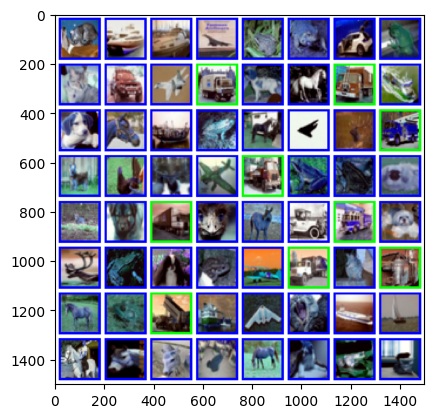

In [18]:
batch = next(iter(test_loader))
imgs, labels = batch
preds = (labels + 1).clamp(0, 9)
preds = torch.nn.functional.one_hot(preds, 10)
# inverse normalization
imgs = (imgs * 0.26158784 + 0.44653091).clamp(0, 1)
grid = create_image_grid(imgs, preds, labels, (8, 8))
plt.imshow(grid)

## Transformer Definition


In [4]:
class TransformerBlock(torch.nn.Module):
    def __init__(
        self,
        embed_dim=256,
        hidden_dim=512,
        q_dim=512,
        v_dim=256,
        num_heads=8,
        dropout=0.0,
        internal_resolution=(32, 32),
        block_index=0,
        kernel_size=1,
    ):
        """Attention Block.

        Args:
            embed_dim: Dimensionality of input and attention feature vectors
            hidden_dim: Dimensionality of hidden layer in feed-forward network
                         (usually 2-4x larger than embed_dim)
            num_heads: Number of heads to use in the Multi-Head Attention block
            dropout: Amount of dropout to apply in the feed-forward network
        """
        super().__init__()

        self.layer_norm_1 = torch.nn.LayerNorm((embed_dim, *internal_resolution))
        self.q_net = torch.nn.Conv2d(
            embed_dim, q_dim, kernel_size=kernel_size, padding=same_padding(kernel_size, format="single")
        )
        self.k_net = torch.nn.Conv2d(
            embed_dim, q_dim, kernel_size=kernel_size, padding=same_padding(kernel_size, format="single")
        )
        self.v_net = torch.nn.Conv2d(
            embed_dim, v_dim, kernel_size=kernel_size, padding=same_padding(kernel_size, format="single")
        )
        self.head_unification = torch.nn.Conv2d(
            v_dim, embed_dim, kernel_size=kernel_size, padding=same_padding(kernel_size, format="single")
        )
        self.layer_norm_2 = torch.nn.LayerNorm((embed_dim, *internal_resolution))
        self.feed_forward = torch.nn.Sequential(
            torch.nn.Conv2d(embed_dim, hidden_dim, kernel_size=kernel_size, padding=same_padding(kernel_size, format="single")),
            torch.nn.GELU(),
            torch.nn.Dropout(dropout),
            torch.nn.Conv2d(hidden_dim, embed_dim, kernel_size=kernel_size, padding=same_padding(kernel_size, format="single")),
            torch.nn.Dropout(dropout),
        )
        self.num_heads = num_heads
        self.block_index = block_index
        self.q_dim = q_dim
        self.v_dim = v_dim
        self.embed_dim = embed_dim

    def break_into_heads(self, M):
        B, D, H, W = M.shape
        h = self.num_heads
        return M.reshape(B, h, D // h, H, W).flatten(0, 1)

    def print_memory(self, prefix):
        pass
        # if self.block_index == 5:
        #     print_memory(prefix)

    def spatial_linear_self_attention(self, Q, K, V):
        """
        Q: (B, Dq, H, W)
        K: (B, Dq, H, W)
        V: (B, Dv, H, W)
        """

        B, Dq, H, W = Q.shape
        _, Dv, _, _ = V.shape
        h = self.num_heads

        assert_shape(Q, (B, Dq, H, W))
        assert_shape(K, (B, Dq, H, W))
        assert_shape(V, (B, Dv, H, W))

        self.print_memory("SA start")

        Q = torch.nn.functional.softmax(Q, dim=-3)
        assert_shape(Q, (B, Dq, H, W))
        self.print_memory("Q softmax")

        K = torch.nn.functional.softmax(K.flatten(-2), dim=-1).reshape(B, Dq, H, W)
        assert_shape(K, (B, Dq, H, W))
        self.print_memory("K softmax")

        Q = self.break_into_heads(Q)
        assert_shape(Q, (B * h, Dq // h, H, W))
        self.print_memory("Q into heads")

        K = self.break_into_heads(K)
        assert_shape(K, (B * h, Dq // h, H, W))
        self.print_memory("K into heads")

        V = self.break_into_heads(V)
        assert_shape(V, (B * h, Dv // h, H, W))
        self.print_memory("V into heads")

        KV = (K.unsqueeze(2) * V.unsqueeze(1)).sum(
            dim=[-1, -2]
        )  # (Bh, Dq // h, 1, H, W) x (Bh, 1, Dv // h, H, W) -> (Bh, Dq // h, Dv // h)
        assert_shape(KV, (B * h, Dq // h, Dv // h))
        self.print_memory("KV inner product")

        KV = KV.unsqueeze(-1).unsqueeze(-1).permute(0, 2, 1, 3, 4).flatten(0, 1)
        assert_shape(KV, (B * h * (Dv // h), Dq // h, 1, 1))
        self.print_memory("KV reshape")

        Q = Q.flatten(0, 1).unsqueeze(0)
        assert_shape(Q, (1, B * h * (Dq // h), H, W))
        self.print_memory("Q reshape")

        QKV = torch.nn.functional.conv2d(Q, KV, groups=B * h)
        assert_shape(QKV, (1, B * h * Dv // h, H, W))
        self.print_memory("QKV convolution")

        QKV = QKV.view(B, Dv, H, W)
        assert_shape(QKV, (B, Dv, H, W))
        self.print_memory("QKV reshape")

        QKV = self.head_unification(QKV)
        self.print_memory("Head unification")

        return QKV

    def spatial_quadratic_self_attention(self, Q, K, V):
        B, Dq, H, W = Q.shape
        _, Dv, _, _ = V.shape
        h = self.num_heads

        assert_shape(Q, (B, Dq, H, W))
        assert_shape(K, (B, Dq, H, W))
        assert_shape(V, (B, Dv, H, W))

        Q = self.break_into_heads(Q)
        assert_shape(Q, (B * h, Dq // h, H, W))

        K = self.break_into_heads(K)
        assert_shape(K, (B * h, Dq // h, H, W))
        self.print_memory("K into heads")

        V = self.break_into_heads(V)
        assert_shape(V, (B * h, Dv // h, H, W))

        Q_image = Q.flatten(0, 1).unsqueeze(0)
        assert_shape(Q_image, (1, B * h * (Dq // h), H, W))

        K_kernels = K.flatten(-2).flatten(0, 1).unsqueeze(-1).unsqueeze(-1)
        assert_shape(K_kernels, (B * h * (Dq // h), H * W, 1, 1))
        K_kernels = K_kernels.permute(1, 0, 2, 3)
        assert_shape(K_kernels, (H * W, B * h * (Dq // h), 1, 1))
        K_kernels = K_kernels.reshape(H * W, B * h, Dq // h, 1, 1).permute(1, 0, 2, 3, 4)
        assert_shape(K_kernels, (B * h, H * W, Dq // h, 1, 1))
        K_kernels = K_kernels.flatten(0, 1)
        assert_shape(K_kernels, (B * h * H * W, Dq // h, 1, 1))

        QK = torch.nn.functional.conv2d(Q_image, K_kernels, groups=B * h)
        assert_shape(QK, (1, B * h * H * W, H, W))
        QK = QK.squeeze(0).reshape(B * h, H * W, H, W).flatten(-2)
        QK = torch.nn.functional.softmax(QK, dim=-1)
        assert_shape(QK, (B * h, H * W, H * W))
        QK = QK.reshape(B * h, H * W, H, W)
        QKV = (QK.unsqueeze(2) * V.unsqueeze(1)).sum(
            dim=[-1, -2]
        )  # (Bh, HW, 1, H, W) x (Bh, 1, Dv//h, H, W) -> (Bh, HW, Dv // h, H, W) -> (Bh, HW, Dv // h)
        assert_shape(QKV, (B * h, H * W, Dv // h))
        QKV = QKV.permute(0, 2, 1).reshape(B * h, Dv // h, H, W)
        assert_shape(QKV, (B * h, Dv // h, H, W))
        QKV = QKV.reshape(B, Dv, H, W)
        assert_shape(QKV, (B, Dv, H, W))

        # Q = Q.reshape(B * h, Dq // h, H * W)
        # assert_shape(Q, (B * h, Dq // h, H * W))

        # K = K.reshape(B * h, Dq // h, H * W)
        # assert_shape(K, (B * h, Dq // h, H * W))

        # QK = torch.bmm(Q.transpose(1, 2), K)  # (B * h, , HW, Dq // h) x (B * h, Dq // h, HW) -> (B * h, HW, HW)
        # QK = torch.nn.functional.softmax(QK, dim=-1)
        # assert_shape(QK, (B * h, H * W, H * W))

        # QKV = torch.bmm(
        #     QK, V.reshape(B * h, Dv // h, H * W).transpose(1, 2)
        # )  # (B * h, HW, HW) x (B * h, HW, Dv // h) -> (B * h, HW, Dv // h)
        # assert_shape(QKV, (B * h, H * W, Dv // h))

        # QKV = QKV.transpose(1, 2).reshape(B, Dv, H, W)
        # assert_shape(QKV, (B, Dv, H, W))

        QKV = self.head_unification(QKV)
        assert_shape(QKV, (B, self.embed_dim, H, W))

        return QKV

    def forward(self, x):
        B, D, H, W = x.shape
        Dq = self.q_dim
        Dv = self.v_dim
        after_norm_1 = self.layer_norm_1(x)
        assert_shape(after_norm_1, (B, D, H, W))
        Q = self.q_net(after_norm_1)
        assert_shape(Q, (B, Dq, H, W))
        K = self.k_net(after_norm_1)
        assert_shape(K, (B, Dq, H, W))
        V = self.v_net(after_norm_1)
        assert_shape(V, (B, Dv, H, W))

        attn = self.spatial_linear_self_attention(Q, K, V)
        assert_shape(attn, (B, D, H, W))
        x = x + attn
        assert_shape(x, (B, D, H, W))
        x = self.layer_norm_2(x)
        assert_shape(x, (B, D, H, W))
        x = x + self.feed_forward(x)
        assert_shape(x, (B, D, H, W))
        return x

## Model Definition


In [5]:
class VisionTransformer(torch.nn.Module):
    def __init__(
        self,
        embed_dim=256,
        hidden_dim=512,
        q_dim=512,
        v_dim=256,
        num_channels=3,
        num_heads=8,
        num_layers=6,
        num_classes=10,
        dropout=0.0,
        patch_equivalent_mode=True,
        patch_width=4,
        input_resolution=(32, 32),
        transformer_kernel_size=1,
    ):
        """Vision Transformer.

        Args:
            embed_dim: Dimensionality of the input feature vectors to the Transformer
            hidden_dim: Dimensionality of the hidden layer in the feed-forward networks
                         within the Transformer
            num_channels: Number of channels of the input (3 for RGB)
            num_heads: Number of heads to use in the Multi-Head Attention block
            num_layers: Number of layers to use in the Transformer
            num_classes: Number of classes to predict
            dropout: Amount of dropout to apply in the feed-forward network and
                      on the input encoding
        """
        super().__init__()

        if patch_equivalent_mode:
            embedding_kernel_size = patch_width
            stride = patch_width
            internal_resolution = (input_resolution[0] // patch_width, input_resolution[1] // patch_width)
        else:
            embedding_kernel_size = 1
            stride = 1
            internal_resolution = input_resolution
        self.input_layer_cnn = torch.nn.Sequential(
            torch.nn.ZeroPad2d(same_padding(embedding_kernel_size) if not patch_equivalent_mode else 0),
            torch.nn.Conv2d(
                num_channels, num_channels, kernel_size=embedding_kernel_size, stride=stride, padding=0, groups=num_channels
            ),
            torch.nn.Conv2d(num_channels, embed_dim, kernel_size=1, stride=1, padding=0),
            torch.nn.GELU(),
        )
        self.transformer = torch.nn.Sequential(
            *(
                TransformerBlock(
                    embed_dim=embed_dim,
                    hidden_dim=hidden_dim,
                    q_dim=q_dim,
                    v_dim=v_dim,
                    num_heads=num_heads,
                    dropout=dropout,
                    internal_resolution=internal_resolution,
                    block_index=block_index,
                    kernel_size=transformer_kernel_size,
                )
                for block_index in range(num_layers)
            )
        )
        self.classification_head = torch.nn.Sequential(torch.nn.LayerNorm(embed_dim), torch.nn.Linear(embed_dim, num_classes))
        self.dropout = torch.nn.Dropout(dropout)

        self.positional_bias = torch.nn.Parameter(torch.randn(embed_dim, *internal_resolution))

    def forward(self, x):
        # Apply depthwise separable convolution embedding
        x = self.input_layer_cnn(x)  # (B, D, H, W)
        B, D, H, W = x.shape

        # Add positional embedding
        pos_embedding = self.positional_bias.unsqueeze(0).repeat(B, 1, 1, 1)  # (B, D, H, W)
        x = x + pos_embedding

        # Apply Transforrmer
        x = self.dropout(x)
        x = self.transformer(x)

        # Global Average Pooling
        pooled = x.reshape(B, D, -1).mean(dim=-1)  # (B, D, H, W) -> (B, D, HW) -> (B, D)

        # Classification
        out = self.classification_head(pooled)
        return out

## Model Wrapper


In [6]:
class ViT(L.LightningModule):
    def __init__(self, lr=None, train_loader=None, val_loader=None, test_loader=None, model_kwargs=None):
        super().__init__()
        self.save_hyperparameters()
        self.model = VisionTransformer(**model_kwargs)
        self.example_input_array = next(iter(train_loader))[0]

    def forward(self, x):
        return self.model(x)

    def configure_optimizers(self):
        optimizer = torch.optim.AdamW(self.parameters(), lr=self.hparams.lr)
        lr_scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[100, 150], gamma=0.1)
        return [optimizer], [lr_scheduler]

    def _calculate_loss(self, batch, mode="train"):
        imgs, labels = batch
        preds = self.model(imgs)
        loss = torch.nn.functional.cross_entropy(preds, labels)
        acc = (preds.argmax(dim=-1) == labels).float().mean()

        self.log("%s_loss" % mode, loss)
        self.log("%s_acc" % mode, acc)
        return loss

    def training_step(self, batch, batch_idx):
        loss = self._calculate_loss(batch, mode="train")
        return loss

    def validation_step(self, batch, batch_idx):
        self._calculate_loss(batch, mode="val")

    def test_step(self, batch, batch_idx):
        self._calculate_loss(batch, mode="test")


def train_model(lr=None, train_loader=None, val_loader=None, test_loader=None, **model_kwargs):
    print("Initializing model and trainer...")
    trainer = L.Trainer(
        default_root_dir=os.path.join(CHECKPOINT_PATH, "ViT"),
        accelerator="auto",
        precision="16-mixed",
        devices=1,
        max_epochs=1,
        callbacks=[
            ModelCheckpoint(save_weights_only=True, mode="max", monitor="val_acc"),
            LearningRateMonitor("epoch"),
        ],
    )
    trainer.logger._log_graph = True  # If True, we plot the computation graph in tensorboard
    trainer.logger._default_hp_metric = None  # Optional logging argument that we don't need

    # Check whether pretrained model exists. If yes, load it and skip training
    print("Checking for pretrained model...")
    pretrained_filename = os.path.join(CHECKPOINT_PATH, "ViT.ckpt")
    # if os.path.isfile(pretrained_filename):
    if False:
        print("Found pretrained model at %s, loading..." % pretrained_filename)
        # Automatically loads the model with the saved hyperparameters
        model = ViT.load_from_checkpoint(pretrained_filename)
    else:
        print("No pretrained model found, training from scratch...")
        L.seed_everything(42)  # To be reproducible
        model = ViT(lr=lr, train_loader=train_loader, val_loader=val_loader, test_loader=test_loader, model_kwargs=model_kwargs)
        trainer.fit(model, train_loader, val_loader)
        # Load best checkpoint after training
        model = ViT.load_from_checkpoint(trainer.checkpoint_callback.best_model_path)

    # Test best model on validation and test set
    val_result = trainer.test(model, dataloaders=val_loader, verbose=False)
    test_result = trainer.test(model, dataloaders=test_loader, verbose=False)
    result = {"test": test_result[0]["test_acc"], "val": val_result[0]["test_acc"]}

    return model, result

## Training the Model


In [7]:
kill_defunct_processes()

!nvidia-smi

from torch.utils.tensorboard import SummaryWriter

class ViT():
    def __init__(self, **hyperparams):
        super().__init__()
        self.model = VisionTransformer(**model_kwargs).to(device)
        self.writer = SummaryWriter()
        self.best_accuracy = 0

    def calculate_loss(self, y_hat, y):
        return torch.nn.functional.cross_entropy(y_hat, y)

    def calculate_accuracy(self, y_hat, y):
        return (y_hat.argmax(dim=-1) == y).float().mean()
    
    def fit(self, train_loader, val_loader, n_epochs=1):
        optimizer = torch.optim.AdamW(self.model.parameters(), lr=3e-4, fused=True)
        scaler = torch.cuda.amp.GradScaler()
        steps_per_epoch = len(train_loader)
        for epoch in range(n_epochs):
            for batch_idx, batch in tqdm(enumerate(train_loader), desc=f"Epoch {epoch+1}", total=steps_per_epoch):
                with torch.autocast(device_type=device, dtype=torch.float16):
                    imgs, labels = batch
                    imgs = imgs.to(device, non_blocking=True)
                    labels = labels.to(device, non_blocking=True)
                    preds = self.model(imgs)
                    loss = self.calculate_loss(preds, labels)
                    with torch.no_grad():
                        accuracy = self.calculate_accuracy(preds, labels)
                
                scaler.scale(loss).backward()
                scaler.step(optimizer)
                scaler.update()
                optimizer.zero_grad(set_to_none=True)

                step = epoch * steps_per_epoch + batch_idx
                self.writer.add_scalar("Loss/train", loss, step)
                self.writer.add_scalar("Accuracy/train", accuracy, step)

            with torch.no_grad():
                accumulated_loss = 0
                accumulated_accuracy = 0
                for batch in tqdm(val_loader, desc=f"Validation {epoch+1}"):
                    with torch.autocast(device_type=device, dtype=torch.float16):
                        imgs, labels = batch
                        imgs = imgs.to(device, non_blocking=True)
                        labels = labels.to(device, non_blocking=True)
                        preds = self.model(imgs)
                        accumulated_loss += self.calculate_loss(preds, labels)
                        accuracy += self.calculate_accuracy(preds, labels)
                accumulated_loss /= len(val_loader)
                accumulated_accuracy /= len(val_loader)

                self.writer.add_scalar("Loss/val", accumulated_loss, epoch)
                self.writer.add_scalar("Accuracy/val", accumulated_accuracy, epoch)

            print(f"Previous best accuracy: {self.best_accuracy:.2f}%, Current accuracy: {accumulated_accuracy:.2f}%")
            if accumulated_accuracy > self.best_accuracy:
                print("Saving model...")
                self.best_accuracy = accumulated_accuracy
                torch.save(vit.state_dict(), "vit.pth")

                
            
    

standard_vit_equivalent_kwargs = {
    "embed_dim": 256,
    "hidden_dim": 512,
    "q_dim": 512,
    "v_dim": 256,
    "num_heads": 8,
    "num_layers": 6,
    "num_channels": 3,
    "num_classes": 10,
    "dropout": 0.2,
    "patch_equivalent_mode": True,
    "patch_width": 4,
    "input_resolution": (32, 32),
    "transformer_kernel_size": 1
}

model_kwargs = standard_vit_equivalent_kwargs

train_loader, val_loader, test_loader = get_dataset(batch_size=64, ds_len=6400)
vit = ViT(**model_kwargs)
vit.fit(train_loader, val_loader, n_epochs=1)



# model, result = train_model(lr=3e-4, train_loader=train_loader, val_loader=val_loader, test_loader=test_loader, **model_kwargs)

# vit = VisionTransformer(**model_kwargs).to(device)
# optimizer = torch.optim.AdamW(vit.parameters(), lr=3e-4, fused=True)
# scaler = torch.cuda.amp.GradScaler()

# n_epochs = 1

# def train():
#     for epoch in range(n_epochs):
#         for batch in tqdm(train_loader, desc=f"Epoch {epoch+1}"):
#             with torch.autocast(device_type=device, dtype=torch.float16):
#                 imgs, labels = batch
#                 imgs = imgs.to(device, non_blocking=True)
#                 labels = labels.to(device, non_blocking=True)
#                 preds = vit(imgs)
#                 loss = torch.nn.functional.cross_entropy(preds, labels)
#             scaler.scale(loss).backward()
#             scaler.step(optimizer)
#             scaler.update()
#             optimizer.zero_grad(set_to_none=True)
            
# train()

Mon Jun 10 19:18:58 2024       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA GeForce RTX 3090        On  |   00000000:41:00.0 Off |                  N/A |
| 45%   44C    P8             24W /  350W |       1MiB /  24576MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

Seed set to 42
Seed set to 42


Files already downloaded and verified


Epoch 1:   0%|          | 0/100 [00:00<?, ?it/s]

Validation 1:   0%|          | 0/682 [00:00<?, ?it/s]

Previous best accuracy: 0.00%, Current accuracy: 0.00%


In [8]:
# Batch size: 64
# ViT (3.2m): 66 it/s
# Standard ViT equivalent (4.4m): 36 it/s